# Hotel Recognition to Combat Human Trafficking | Train
    2021-05-09
    Edward Sims




## 1.00 Import Packages

In [1]:
# General packages
import pandas as pd
import numpy as np
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook
import cv2
from datetime import datetime as dt
import pickle

import time
import warnings
import multiprocessing

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling packages
import tensorflow.compat.v1 as tf
from tensorflow import keras
from keras import backend as k
# Key layers
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Add, Dense, Flatten
# Activation layers
from keras.layers import ReLU, LeakyReLU, ELU, ThresholdedReLU
# Dropout layers
from keras.layers import Dropout, AlphaDropout, GaussianDropout
# Normalisation layers
from keras.layers import BatchNormalization
# Embedding layers
from keras.layers import Embedding, Concatenate, Reshape
# Callbacks
from keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
# Optimisers
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
# Model cross validation and evaluation
from sklearn.model_selection import KFold
from keras.losses import binary_crossentropy

# For Bayesian hyperparameter searching
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

# Package options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = [14, 8]

In [2]:
# Check GPU config
print(f"Number of GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

# Get number of cpu cores for multiprocessing
try:
    cpus = int(multiprocessing.cpu_count() / 4)
except NotImplementedError:
    cpus = 1 # Default number of cores
    
print(f"Number of CPU Cores: {cpus}")

# Disable eager execution for mAP metric
tf.compat.v1.disable_eager_execution()

Number of GPUs Available: 1
REPLICAS: 1
Number of CPU Cores: 32


## 2.00 Data Preparation
### 2.01 Read in Data

In [3]:
# Data paths
data_dir_path         = "../input/hotel-id-2021-fgvc8"
train_images_dir_path = os.path.join(data_dir_path, "train_images")
test_images_dir_path  = os.path.join(data_dir_path, "test_images")

train_metadata_path   = os.path.join(data_dir_path, "train.csv")
sample_sub_path       = os.path.join(data_dir_path, "sample_submission.csv")

# Read csv data
train_metadata        = pd.read_csv(train_metadata_path, parse_dates=["timestamp"])
sample_sub            = pd.read_csv(sample_sub_path)

### 2.02 Set default parameters

In [4]:
# Define key parameters
SEED = 14
np.random.seed(SEED)

ROWS     = 128 # Default row size
COLS     = 128 # Default col size
CHANNELS = 3

EPOCHS = 100
BATCH_SIZE = 64
KFOLDS = 2
PATIENCE = 10

# Read all images in and subset in CV? Or Read images inside each fold in CV?
read_images_in_fold = False

MODEL_TO_USE = "resnet50"
model_name_save = MODEL_TO_USE + "_" + str(ROWS) + "x" + str(COLS) + "_seed" + str(SEED)

# Create weights path if does not exist already
if not os.path.exists(f"weights/{model_name_save}"):
    os.mkdir(f"weights/{model_name_save}")
    
print(f"Model name: {model_name_save}")

train_sample = 500

Model name: resnet50_128x128_seed14


In [5]:
# Metadata preparation
def get_is_weekend(timestamp_col):
    """
    Returns boolean for whether timestamp is a weekend.
    """
    timestamp_col_weekday = timestamp_col.dt.weekday
    # Allocate booleans - Weekends are designated 6 & 7
    timestamp_col_weekday = timestamp_col_weekday.apply(lambda x: False if x < 5 else True)
    
    return timestamp_col_weekday

# Extract year, month and hour from timestamp feature
train_metadata["year"] = train_metadata["timestamp"].dt.year
train_metadata["month"] = train_metadata["timestamp"].dt.month
train_metadata["hour"] = train_metadata["timestamp"].dt.hour
# Extract is_weekend from timestamp
train_metadata["is_weekend"] = get_is_weekend(train_metadata["timestamp"])
train_metadata = train_metadata.drop("timestamp", axis=1)

# Extract labels from metadata
y_train = np.array(train_metadata["hotel_id"])[0:train_sample]

### 2.03 Read Images

In [6]:
def get_image_paths(image_dir_path):
    """Reads images into np.array from directory of image files.

    Parameters
    ----------
    image_dir : list
        Directory of images to read from.

    Returns
    -------
    list
        List of images paths to.

    """
    # Get list of all image paths
    image_path_list = []
    try:
        for chain_id in os.listdir(image_dir_path):
            # Each subdirectory is a chain_id
            chain_id_dir_path = os.path.join(image_dir_path, chain_id)
            # Read images from each chain_id subdirectory
            for image in os.listdir(chain_id_dir_path): 
                # Read image
                image_path = os.path.join(chain_id_dir_path, image)
                # Append to list of images
                image_path_list.append(image_path)
    except NotADirectoryError:
        # Read images from each chain_id subdirectory
        for image in os.listdir(image_dir_path): 
            # Read image
            image_path = os.path.join(image_dir_path, image)
            # Append to list of images
            image_path_list.append(image_path)

    # Remove all non-jpg files
    for idx, path in enumerate(image_path_list):
        if ".jpg" not in path and ".png" not in path:
            del image_path_list[idx]
    
    return image_path_list


def load_image(image_path, rows=ROWS, cols=COLS):
    """
    Read and return single resized image.
    """
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (rows, cols))
        return image
    except:
        pass


In [7]:
# Get all full image paths
train_images_path_list = get_image_paths(train_images_dir_path)
test_images_path_list = get_image_paths(test_images_dir_path)

### 2.04 Image Augmentations

In [8]:
def preprocess_imgs(train_imgs, test_imgs, verbose=0):
    """Centers images by minusing the mean and dividing by std
    
    Parameters
    ----------
    train_imgs : array 
        Train images to read in and normalise
    test_imgs : array
        Test images to read in and normalise
        
    Returns
    -------
    np.array
        2 np.arrays including original images and augmented images (for train and test set).
    """
    
    if verbose == 1:
        print("Preprocessing images...\n")
    # Convert pixel values to float
    train_imgs = train_imgs.astype(float)
    test_imgs = test_imgs.astype(float)

    # Get per-channel means and stds    
    train_means = train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)
    train_stds = train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)

    # Standardise images
    train_imgs -= train_means
    train_imgs /= train_stds
    
    test_imgs -= train_means
    test_imgs /= train_stds
    
    if verbose == 1:
        print(f"Train per-channel means: {train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)}")
        print(f"Trin per-channel stds: {train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)}")

    return train_imgs, test_imgs

In [9]:
def make_train_augmentations(train_imgs, y, p, aug, verbose=0):
    """Make a random subset of p proportion. Apply augmentations
        to the subset and append back to the original dataset, 
        making necessary changes to labels.
    
    Parameters
    ----------
    train_imgs : array
        Train images to read in and augment
    y : array
        Train labels to copy as per augmented images
    p : float
        sample size probability
    aug : string
        Choice of augmentation from ['fliplr', 'rot90', 'rot180']
        
    Returns
    -------
    np.array
        np.array of original images and augmented images and their corresponding labels.
    """
    
    if verbose == 1:
        print('Augmenting images...')
    # Get a sample of X and y based on p proportion
    sample_size = int(round(len(y) * p))
    idx_sample = random.sample(range(0, len(y), 1), sample_size)

    # Make augmentations to sample
    if aug == "fliplr":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.fliplr(train_imgs[i]) for i in idx_sample])),
            axis=0
        )
    elif aug == "rot90":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.rot90(train_imgs[i], 1) for i in idx_sample])),
            axis=0
        )
    elif aug == "rot180":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.rot90(train_imgs[i], 2) for i in idx_sample])),
            axis=0
        )
    
    # Copy labels accordingly
    y_sample = np.array([y[i] for i in idx_sample])
    y = np.concatenate((y, y_sample), axis=0)

    return train_imgs, y

In [10]:
if read_images_in_fold == False:
    # Read in train and test images asynchrously
    pool = multiprocessing.Pool(processes=cpus)
    train_images = np.array(pool.map(load_image, train_images_path_list[0:train_sample]))
    test_images = np.array(pool.map(load_image, test_images_path_list))
    pool.close()
    pool.join()
    
    print(f"Train images shape: {train_images.shape}")

Train images shape: (500, 128, 128, 3)


## 3.00 Modelling
### 3.01 Learning Rate

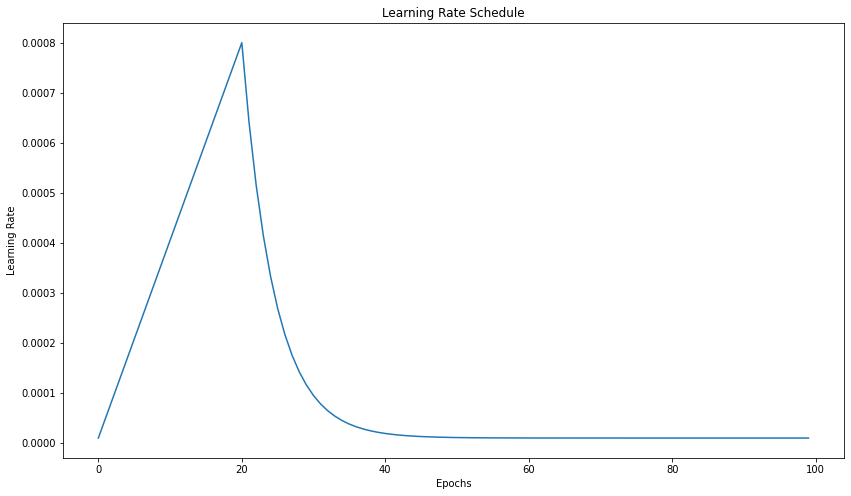

In [11]:
def build_lrfn(lr_start          = 0.00001, 
               lr_max            = 0.0008, 
               lr_min            = 0.00001, 
               lr_rampup_epochs  = 20, 
               lr_sustain_epochs = 0, 
               lr_exp_decay      = 0.8):
    
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr

    return lrfn

lrfn = build_lrfn()
lr = LearningRateScheduler(lrfn, verbose=0)

plt.plot([lrfn(epoch) for epoch in range(EPOCHS)])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### 3.02 Compiler Metrics

In [12]:
# Define Mean Average Precision at K metric
map_at_k = tf.compat.v1.metrics.average_precision_at_k

In [13]:

#y_true = np.array([[4], [4], [4], [4], [4]]).astype(np.int64)
#y_true = tf.identity(y_true)
#
#y_pred = np.array([[0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6]
#                   ]).astype(np.float32)
#y_pred = tf.identity(y_pred)
#
#_, m_ap = map_at_k(y_true, y_pred, 5)
#
#sess = tf.Session()
#sess.run(tf.local_variables_initializer())
#
#stream_vars = [i for i in tf.local_variables()]
#
#tf_map = sess.run(m_ap)
#print(tf_map)
#
#tmp_rank = tf.nn.top_k(y_pred, 5)
#
#print(sess.run(tmp_rank))

### 3.03 CNN Models

In [ ]:
# The model we'll feed the images into before concatenation
def get_cnn_model(kfold, model_to_use=MODEL_TO_USE, verbose=1):
    """Returns the model object and the name of the final layer in the model.
    
    Parameters
    ----------
    kfold : int 
        Fold that the CV is currently on (to determine img size)
    model_to_use : str 
        Model to retrieve
    verbose : int
        Level of output communication. 0=None, 1=All.
    """
    if verbose == 1:
        print("\nLoading pretrained model...")
                        
    input_shape = (
        kfold_params[kfold]["ROWS"],
        kfold_params[kfold]["COLS"],
        CHANNELS
    )
    
    # DenseNet121
    if model_to_use == "densenet121":
        from tensorflow.keras.applications import DenseNet121
        model_return = DenseNet121(include_top=False, input_shape=input_shape)
        
    # DenseNet169
    elif model_to_use == "densenet169":
        from tensorflow.keras.applications import DenseNet169
        model_return = DenseNet169(include_top=False, input_shape=input_shape)
        
    # DenseNet201
    elif model_to_use == "densenet201":
        from tensorflow.keras.applications import DenseNet201
        model_return = DenseNet201(include_top=False, input_shape=input_shape)
            
    # EfficientNet_B0
    elif model_to_use == "efficientnet_b0":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB0(include_top=False, weights=efficientnet_b0_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B1
    elif model_to_use == "efficientnet_b1":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB1(include_top=False, weights=efficientnet_b1_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B2
    elif model_to_use == "efficientnet_b2":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB2(include_top=False, weights=efficientnet_b2_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B3
    elif model_to_use == "efficientnet_b3":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB3(include_top=False, weights=efficientnet_b3_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B4
    elif model_to_use == "efficientnet_b4":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB4(include_top=False, weights=efficientnet_b4_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B5
    elif model_to_use == "efficientnet_b5":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB5(include_top=False, weights=efficientnet_b5_weights,
                                         input_shape=input_shape)

    # InceptionResNetV2
    elif model_to_use == "inception_resnetv2":
        from tensorflow.keras.applications import InceptionResNetV2
        model_return = InceptionResNetV2(include_top=False, weights=inception_resnetv2_weights,
                                               input_shape=input_shape)

    # InceptionV3
    elif model_to_use == "inceptionv3":
        from tensorflow.keras.applications import InceptionV3
        model_return = InceptionV3(include_top=False, weights=inceptionv3_weights,
                                  input_shape=input_shape)
    
    # ResNet50V2
    elif model_to_use == "resnet50v2":
        from tensorflow.keras.applications import ResNet50V2
        model_return = ResNet50V2(include_top=False, weights=resnet50v2_weights,
                                input_shape=input_shape)

    # ResNet101V2
    elif model_to_use == "resnet101v2":
        from tensorflow.keras.applications import ResNet101V2
        model_return = ResNet101V2(include_top=False, weights=resnet101v2_weights,
                                  input_shape=input_shape)

    # ResNet152V2
    elif model_to_use == "resnet152v2":
        from tensorflow.keras.applications import ResNet152V2
        model_return = ResNet152V2(include_top=False, weights=resnet152v2_weights,
                                  input_shape=input_shape)

    # ResNeXt50
    elif model_to_use == "resnext50":
        from keras_applications.resnext import ResNeXt50
        model_return = ResNeXt50(include_top=False, weights=resnext50_weights,
                              input_shape=input_shape,
                              backend=keras.backend, 
                              layers=keras.layers, 
                              models=keras.models, 
                              utils=keras.utils)

    # ResNeXt101
    elif model_to_use == "resnext101":
        from keras_applications.resnext import ResNeXt101
        model_return = ResNeXt101(include_top=False, weights=resnext101_weights,
                                input_shape=input_shape,
                                backend=keras.backend, 
                                layers=keras.layers, 
                                models=keras.models, 
                                utils=keras.utils)
        
    # VGG19
    elif model_to_use == "vgg19":
        from tensorflow.keras.applications import VGG19
        model_return = VGG19(include_top=False, weights=vgg19_weights,
                      input_shape=input_shape)

    # Xception
    elif model_to_use == "xception":
        from tensorflow.keras.applications import Xception
        model_return = Xception(include_top=False, weights=xception_weights,
                                  input_shape=input_shape)
        
    return(model_return)